<a href="https://colab.research.google.com/github/aryan-cs/poker-like-games/blob/discrete-poker/discrete_poker_games.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# -1. Preface
While the paper designates letters to each player (Player A, Player B), the code makes use of integers for readability.

`P1`, `p1_foo` → Player A, Property of Player A

`P2`, `p2_foo` → Player B, Property of Player B

# 0. Setup
Run this cell to set up some helpful tools.

In [10]:
import time
import pandas as pd
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt
from rich.console import Console
from rich.table import Table

log_data = []
P1 = True
P2 = True

RED = "#ff2684"
BLUE = "#19beff"
WHITE = "#ebebeb"
GRAY = "#858585"

# First player has n options, second player has n - 1 options (picking without replacement)
def nCr(n): return n * (n - 1) # / 2

# Saving -- irrelevant
def log(p1_cutoff, p2_cutoff, p1_expected_payout, p2_expected_payout, time_taken, verbose=True):
    log_data.append({
        'p1_cutoff': p1_cutoff,
        'p2_cutoff': p2_cutoff,
        'p1_expected_payout': p1_expected_payout,
        'p2_expected_payout': p2_expected_payout,
        'time_taken': time_taken
    })

    message = '''
P1 Cutoff: {0}
P2 Cutoff: {1}
P1 Payout: {2:.5f}
P2 Payout: {3:.5f}
Executed in {4:.5f} seconds
'''.format(p1_cutoff,
            p2_cutoff,
            p1_expected_payout,
            p2_expected_payout,
            time_taken)

    if verbose: boxed(message)

# Visual appeal -- irrelevant
def boxed(text):
    lines = text.splitlines()
    if lines and lines[0] == "": lines = lines[1:]
    if not lines: return

    max_width = max(map(len, lines))

    print("┌" + "─" * (max_width + 2) + "┐")
    for line in lines:
      print(f"│ {line.ljust(max_width)} │")
    print("└" + "─" * (max_width + 2) + "┘")

# Graphing -- irrelevant
def graph_scatter_3d(p1=False, p2=False):
    df = pd.DataFrame(log_data)
    fig = go.Figure()

    if p1:
        fig.add_trace(go.Scatter3d(
            x=df['p1_cutoff'],
            y=df['p2_cutoff'],
            z=df['p1_expected_payout'],
            mode='markers',
            marker=dict(color='blue', size=4),
            name='Player 1'
        ))

    if p2:
        fig.add_trace(go.Scatter3d(
            x=df['p1_cutoff'],
            y=df['p2_cutoff'],
            z=df['p2_expected_payout'],
            mode='markers',
            marker=dict(color='red', size=4),
            name='Player 2'
        ))

    fig.update_layout(
        title='Payouts as a function of Cutoffs | Scatter',
        scene=dict(
            xaxis_title='P1 Cutoff',
            yaxis_title='P2 Cutoff',
            zaxis_title='Payout'
        ),
        showlegend=True
    )

    fig.show()

# Graphing -- irrelevant
def graph_contour_3d(p1=False, p2=False):
    df = pd.DataFrame(log_data).groupby(['p1_cutoff', 'p2_cutoff'], as_index=False).mean()
    fig = go.Figure()

    x = np.unique(df['p1_cutoff'])
    y = np.unique(df['p2_cutoff'])
    X, Y = np.meshgrid(x, y)

    if p1:
        Z1 = df.pivot_table(
            index='p2_cutoff',
            columns='p1_cutoff',
            values='p1_expected_payout').values
        fig.add_trace(go.Surface(x=X, y=Y, z=Z1,
                                 colorscale='Blues',
                                 opacity=0.9,
                                 name="Player 1 Payout"))

    if p2:
        Z2 = df.pivot_table(
            index='p2_cutoff',
            columns='p1_cutoff',
            values='p2_expected_payout').values
        fig.add_trace(go.Surface(x=X, y=Y, z=Z2,
                                 colorscale='Reds',
                                 opacity=0.9,
                                 name="Player 2 Payout"))

    fig.update_layout(
        title='Payouts as a function of Cutoffs | Contour',
        scene=dict(
            xaxis_title='P1 Cutoff',
            yaxis_title='P2 Cutoff',
            zaxis_title='Payout'
        ),
        showlegend=True
    )

    fig.show()

# Displaying payoff matrix -- irrelevant
def expected_payoffs_table(p1=False, p2=False):
    if p1 and p2:
        boxed("Please use only one flag per table.")
        return

    console = Console()
    df = pd.DataFrame(log_data).groupby(['p1_cutoff', 'p2_cutoff'], as_index=False).mean()

    if p1:
        pivot = df.pivot(index='p1_cutoff', columns='p2_cutoff', values='p1_expected_payout')
        title = "E(c1, c2) for P1 | " + str(n) + " x " + str(n)
    elif p2:
        pivot = df.pivot(index='p1_cutoff', columns='p2_cutoff', values='p2_expected_payout')
        title = "E(c1, c2) for P2 | " + str(n) + " x " + str(n)
    else:
        boxed("Please specify either p1=True or p2=True")
        return

    table = Table(title=title, show_lines=True, padding=(0, 1), collapse_padding=True)
    table.add_column("C", style=WHITE, justify="right")

    for col in pivot.columns:
        table.add_column(f"{col}", justify="right")

    def format_value(val):
        if pd.isnull(val):
            return f"[#ebebeb]-[/#ebebeb]"
        color = BLUE if val > 0 else RED if val < 0 else WHITE
        formatted_val = f"{int(val)}" if val == int(val) else f"{val:.5f}"
        return f"[{color}]{formatted_val}[/{color}]"

    for idx, row in pivot.iterrows():
        idx_formatted = f"{int(idx)}" if idx == int(idx) else f"{idx:.2f}"
        table_row = [idx_formatted] + [format_value(val) for val in row]
        table.add_row(*table_row, end_section=True)

    console.print(table)

def graph_2d():
  df = pd.DataFrame(log_data).groupby(['p1_cutoff', 'p2_cutoff'], as_index=False).mean()
  plt.figure(figsize=(10, 6))
  plt.plot(df['p1_cutoff'],df['p1_expected_payout'])

# Exporting -- irrelevant
def save():
    df = pd.DataFrame(log_data)
    df.to_csv('data.csv', index=False)


# 1. Simulation of Opposing Cutoff Strategies
Simulating payoffs for various cutoff combinations.

┌───────────────────────────────────────────┐
│ Executed all iterations in 0.003 seconds. │
└───────────────────────────────────────────┘


               E(c1, c2) for P1 | 10 x 10               
┏━━━━┳━━━━┳━━━━┳━━━━┳━━━━┳━━━━┳━━━━┳━━━━┳━━━━┳━━━━┳━━━━┓
┃  C ┃  1 ┃  2 ┃  3 ┃  4 ┃  5 ┃  6 ┃  7 ┃  8 ┃  9 ┃ 10 ┃
┡━━━━╇━━━━╇━━━━╇━━━━╇━━━━╇━━━━╇━━━━╇━━━━╇━━━━╇━━━━╇━━━━┩
│  1 │-12 │-12 │-12 │-12 │-12 │-12 │-12 │-12 │-12 │-12 │
├────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┤
│  2 │-12 │-12 │-12 │-12 │-12 │-12 │-12 │-12 │-12 │-12 │
├────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┤
│  3 │-10 │-10 │-10 │-10 │-10 │-10 │-10 │-10 │-10 │-10 │
├────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┤
│  4 │ -6 │ -6 │ -6 │ -6 │ -6 │ -6 │ -6 │ -6 │ -6 │ -6 │
├────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┤
│  5 │  0 │  0 │  0 │  0 │  0 │  0 │  0 │  0 │  0 │  0 │
├────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┤
│  6 │  5 │  5 │  5 │  5 │  5 │  5 │  5 │  5 │  5 │  5 │
├────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┤
│  7 │  6 │  6 │  6 │  6 │  6 │  6 │  6 │  6 │  6 │  6 │
├────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┤
│  8 │  3 │  3 │  3 │  3 │  3 │  3 │  3 │  3 │  3 │  3 │
├────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┤
│  9 │ -4 │ -4 │ -4 │ -4 │ -4 │ -4 │ -4 │ -4 │ -4 │ -4 │
├────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┤
│ 10 │-15 │-15 │-15 │-15 │-15 │-15 │-15 │-15 │-15 │-15 │
└────┴────┴────┴────┴────┴────┴────┴────┴────┴────┴────┘

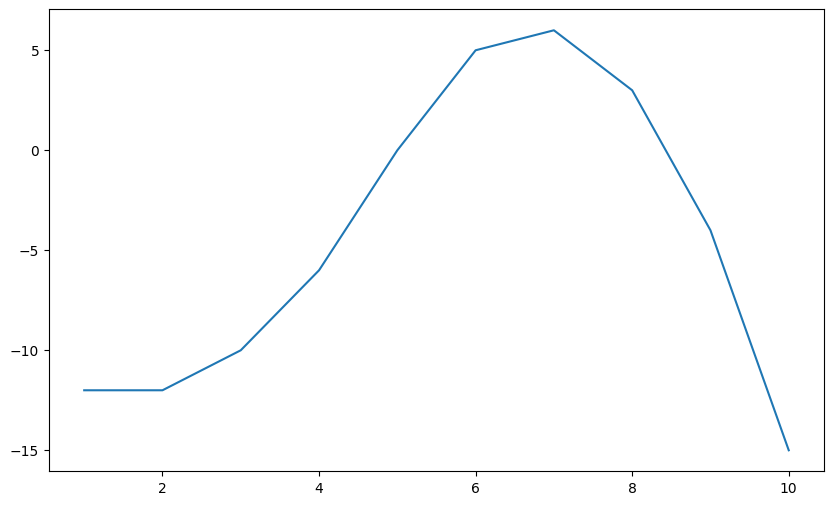

In [5]:
#@title { vertical-output: true }

"""

  Example n values:
    n = 3: Ace/King/Queen
    n = 6: Dice
    n = 13: Full Suit Poker
    n = 1000: Roughly continuous

  Iterating for cutoff ranges of [1, test_range]

"""
n = 10
test_range = n
p1_expected_payout, p2_expected_payout = 0, 0
trials = nCr(n)

def test_cutoffs(p1_cutoff, p2_cutoff):

  start_time = time.time()

  global p1_expected_payout
  global p2_expected_payout

  p1_expected_payout = 0
  p2_expected_payout = 0

  # Testing every possible 'card' for Player A and Player B
  for p1_card in range(1, n + 1):
    for p2_card in range(1, n + 1):

      if p1_card == p2_card: continue

      # Player A in betting region, Player B in betting region
      if p1_card >= p1_cutoff and p2_card >= p2_cutoff:

        # Case BBW
        if p1_card > p2_card:       # Player A wins showdown
          p1_expected_payout += 2
          p2_expected_payout -= 2

        # Case BBL
        else:                       # Player B wins showdown
          p1_expected_payout -= 2
          p2_expected_payout += 2

      # Player A in folding region, Player B in folding region
      elif p1_card < p1_cutoff and p2_card < p2_cutoff:

        # Case FFW
        if p1_card > p2_card:       # Player A wins showdown
          p1_expected_payout += 1
          p2_expected_payout -= 1

        # Case FFL
        else:                       # Player B wins showdown
          p1_expected_payout -= 1
          p2_expected_payout += 1

      # Player A in betting region, Player B in folding region | Player B forfeits, Player A wins by default
      elif p1_card >= p1_cutoff:

        # Case BFW
        p1_expected_payout += 1
        p2_expected_payout -= 1

      # Player A in folding region, Player B in betting region | Player A forfeits, Player B wins by default
      elif p2_card >= p2_cutoff:

        # Case FBL
        p1_expected_payout -= 1
        p2_expected_payout += 1

  return time.time() - start_time

log_data = []
start_time = time.time()

'''
  Testing all possible cutoffs
  A cutoff is defined as the minimum value a player must have in order to bet
'''
for p1_test_cutoff in range(1, test_range + 1):
  for p2_test_cutoff in range(1, test_range + 1):
    # timeTaken = test_cutoffs(p1_test_cutoff, p2_test_cutoff)
    timeTaken = test_cutoffs(p1_test_cutoff, n / 2)
    log(p1_test_cutoff,
        p2_test_cutoff,
        # p1_expected_payout / trials,
        # p2_expected_payout / trials,
        p1_expected_payout,
        p2_expected_payout,
        timeTaken,
        verbose=False)

boxed(f"Executed all iterations in {round(time.time() - start_time, 3)} seconds.\n")

# Add flags as necessary (P1, P2)
# graph_scatter_3d(P1)
# graph_contour_3d(P1)
graph_2d()
expected_payoffs_table(P1)
save()

# 2. Determining if Cutoff Strategy is Dominiant

This code iterates over all 2^n pure strategies for both players and checks to see if the Cutoff Strategy payout yields is greater than or equal to the payout by any other strategy. We find that the Cutoff Strategy is ***not*** a dominant strategy.


In [12]:
#@title { vertical-output: true }

import itertools

n = 3

# Returns the index/indices of the highest values in the array
def indices_of_max(data):
    if not data: return []
    max_value = max(data)
    return [index for index, value in enumerate(data) if value == max_value]

# Returns the powerset (size 2^N)
def subsets_size_n(s, N):
    return list(itertools.combinations(s, N))

p1_payouts = []
p1_strategies = []

# For each card N in [0, 1, 2, 3... n]
for N in range(0, n + 1):

    # For each cutoff C in [1, 2, 3... n]
    p1_cutoffs = [i for i in range(1, n + 1)]
    p2_cutoffs = [i for i in range(1, n + 1)]

    # Generate the betting set for Player B
    # Ex: n = 3, { [], [1], [2], [3], [1, 2], [1, 3], [2, 3], [1, 2, 3] }
    for p2_betting_set in subsets_size_n(p2_cutoffs, N):

        p1_payouts.clear()
        p1_strategies.clear()

        # For each card M in [0, 1, 2, 3... n]
        for M in range(0, n + 1):

            # Generate the betting set for Player A
            # Ex: n = 3, { [], [1], [2], [3], [1, 2], [1, 3], [2, 3], [1, 2, 3] } x 2^N
            for p1_betting_set in subsets_size_n(p1_cutoffs, M):

                p1_expected_payout = 0
                p2_expected_payout = 0

                # Like before, iterate through all possible single-card hands
                for p1_card in range(1, n + 1):
                    for p2_card in range(1, n + 1):

                        # Draw without replacement, skip repeats
                        if p1_card == p2_card:
                            continue

                        # Player A will bet, Player B will bet
                        if (p1_card in p1_betting_set) and (p2_card in p2_betting_set):

                            # Case BBW
                            if p1_card > p2_card:         # Player A wins showdown
                                p1_expected_payout += 2
                                p2_expected_payout -= 2
                            # Case BBL
                            else:                         # Player B wins showdown
                                p1_expected_payout -= 2
                                p2_expected_payout += 2

                        # Player A will not bet, Player B will not bet
                        elif (p1_card not in p1_betting_set) and (p2_card not in p2_betting_set):

                            # Case FFW
                            if p1_card > p2_card:         # Player A wins showdown
                                p1_expected_payout += 1
                                p2_expected_payout -= 1
                            # Case FFL
                            else:                         # Player B wins showdown
                                p1_expected_payout -= 1
                                p2_expected_payout += 1

                        # Player A will bet, Player B will not bet (automatic win for Player A)
                        elif (p1_card in p1_betting_set) and (p2_card not in p2_betting_set):

                            # Case BFL
                            p2_expected_payout -= 1
                            p1_expected_payout += 1

                        # Player A will not bet, Player B will bet (automatic win for Player B)
                        elif (p1_card not in p1_betting_set) and (p2_card in p2_betting_set):

                            # Case FBL
                            p2_expected_payout += 1
                            p1_expected_payout -= 1

                # Track strategies & payouts
                p1_strategies.append(p1_betting_set)
                p1_payouts.append(p1_expected_payout)

        p1_maxes = indices_of_max(p1_payouts) # Get the maximum payout per strategy
        bad_strategies = []
        bad_payouts = 2
        is_possible = False

        for index in p1_maxes:
            strat = list(p1_strategies[index])
            works = True

            for i in range(0, len(strat)):
              # Check if strategy is in descending order [n, n - 1, n - 2... 1]
              # Strategy can only work if it is
              if strat[len(strat) - i - 1] != n - i: works = False

            if works: is_possible = True

            # Otherwise, recognize it as a bad/invalid strategy
            else:
                bad_strategies = p1_strategies[index]
                bad_payouts = p1_payouts[index]

        # Print the optimal strategy for Player A given Player B's strategy
        # boxed(
        #     "P1 Strat: " + str(p1_strategies[index]) + "\n" +
        #     "Payout: " + str(p1_payouts[index])
        # )

        if is_possible: continue

        boxed(
            "P2 Strat: " + str(p2_betting_set) + "\n"
            "Payout: " + str(bad_payouts) + "\n"
            "Not Cutoff P1 Strat: " + str(bad_strategies) + "\n"
        )


┌─────────────────────────────┐
│ P2 Strat: (3,)              │
│ Payout: 1                   │
│ Not Cutoff P1 Strat: (1, 3) │
└─────────────────────────────┘
